In [1]:
from pathlib import Path

from src.dino.opencv import read_image, write_image
from src.tone_mappers.bronto import bronto
from src.tone_mappers.exposure import exposure_luminance
from src.tone_mappers.linear import linear_luminance
from src.tone_mappers.reinhard import reinhard_luminance


INPUT_IMAGE = Path("images/507.exr")
image = read_image(str(INPUT_IMAGE))
OUTPUT_PATH = Path("_output")

# for pct in [100, 90, 80, 70, 60]:
#     linear_tonemapped = linear_luminance(image, pct=pct)
#     file_path = f"{OUTPUT_PATH / INPUT_IMAGE.stem}_linear_p{pct}.png"
#     write_image(file_path, linear_tonemapped)
#     print("Exported", file_path)

# for key in [0.05, 0.1, 0.18, 0.25, 0.4]:
#     exposure_tonemapped = exposure_luminance(image, key=key)
#     file_path = f"{OUTPUT_PATH / INPUT_IMAGE.stem}_exposure_k={key}.png"
#     write_image(file_path, exposure_tonemapped)
#     print("Exported", file_path)

reinhard_tonemapped = reinhard_luminance(image, gamma=1)
file_path = f"{OUTPUT_PATH / INPUT_IMAGE.stem}_reinhard_default.png"
write_image(file_path, reinhard_tonemapped)
print("Exported", file_path)

bronto_tonemapped = bronto(image, gamma=1)
file_path = f"{OUTPUT_PATH / INPUT_IMAGE.stem}_bronto_defaults.png"
write_image(file_path, bronto_tonemapped)
print("Exported", file_path)

[ WARN:0@4.746] global loadsave.cpp:848 imwrite_ Unsupported depth image for selected encoder is fallbacked to CV_8U.


Exported _output/507_reinhard_default.png
Exported _output/507_bronto_defaults.png


In [3]:
from pathlib import Path

from src.dino.opencv import read_image, write_image
from src.tone_mappers.bronto import *

def bronto_L_bar(
    rgb_image: np.ndarray,
    cs_ratio: float = 2.0,
    num_scales: int = 13,
    gamma: float = 1.0,
    k: float = 0.3,
    w: float = 0.9,
    m: float = 0.1,
    d_nit_arcmin2: float = 100,
    image_fov_degrees: float = 72,
) -> np.ndarray:
    """BRightness Optimized Normalization Tone-mapping Operator."""
    X, Y, Z = rgb_to_xyz(rgb_image)
    L, x_chroma, y_chroma = xyz_to_lxy(X, Y, Z)
    L_gamma = L ** (1 / gamma)
    width = L.shape[1]
    d = arcmin2_to_pixel2(d_nit_arcmin2, width, image_fov_degrees)

    scales = generate_scales(width, cs_ratio, num_scales)
    weights = [w**i for i in range(len(scales))]
    center_response_gamma = gaussian_blur(L_gamma, scales[0])
    accum = np.zeros_like(L)
    c_sum = np.zeros_like(L)

    for i in range(1, len(scales)):
        surround_response = gaussian_blur(L, scales[i])
        surround_response_gamma = surround_response if gamma == 1 else gaussian_blur(L_gamma, scales[i]) 
        w = weights[i - 1]
        _d = d / scales[i] ** 2
        c = w * np.abs((center_response_gamma + _d) / (surround_response_gamma + _d) - 1) + m
        accum += c * surround_response
        c_sum += c
        center_response_gamma = surround_response_gamma

    return accum / c_sum


INPUT_IMAGE = Path("images/DelicateArch.exr")
image = read_image(str(INPUT_IMAGE))
OUTPUT_PATH = Path("_output")
blurred = bronto_L_bar(image)

(np.float64(-0.5), np.float64(4287.5), np.float64(2679.5), np.float64(-0.5))

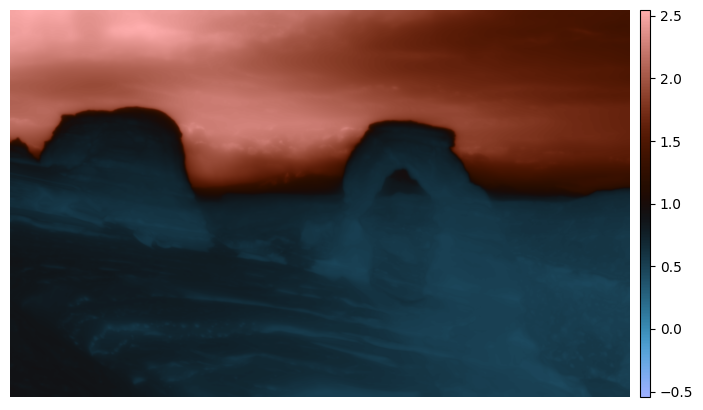

In [29]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.colors import CenteredNorm

inverse_blurred = 1 / blurred
fig = plt.figure()
grid = ImageGrid(
    fig,
    (0, 0, 1, 1),
    nrows_ncols=(1, 1),
    axes_pad=(0.35, 0.05),
    cbar_location="right",
    cbar_mode="each",
    cbar_size=0.1,
    cbar_pad=0.1,
)
ax = grid[0]
cax = grid.cbar_axes[0]
im = ax.imshow(blurred, cmap="berlin", aspect="equal", norm=CenteredNorm(vcenter=1))
cbar = cax.colorbar(im)
ax.axis("off")